# Video Captioning

In [1]:
#Import important libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import math
from preprocess_videos import load_df, preprocess_df, get_final_list, extract_frames, select_videos, load_video_frames, extract_features, view_frames
from enc_dec_models import basic_enc_dec

Preprocessing

In [2]:
#Import captions
df = load_df("dataset/msvd_videos/video_corpus.csv")
df.head()

VideoID  Start  End  WorkerID      Source  AnnotationTime    Language  \
0  mv89psg6zh4     33   46    588702  unverified              55     Slovene   
1  mv89psg6zh4     33   46    588702  unverified              37     Slovene   
2  mv89psg6zh4     33   46    362812  unverified              11  Macedonian   
3  mv89psg6zh4     33   46    968828  unverified              84      German   
4  mv89psg6zh4     33   46    203142  unverified              14    Romanian   

                                        Description  
0        Papagaj se umiva pod tekočo vodo v lijaku.  
1        Papagaj se umiva pod tekočo vodo v lijaku.  
2                                   папагал се бања  
3  Ein Wellensittich duscht unter einem Wasserhahn.  
4                     o pasare sta intr-o chiuveta.

In [3]:
data = preprocess_df(df)

In [4]:
data.head()

Name                                        Description
18  mv89psg6zh4_33_46  A bird in a sink keeps getting under the runni...
19  mv89psg6zh4_33_46                       A bird is bathing in a sink.
20  mv89psg6zh4_33_46  A bird is splashing around under a running fau...
21  mv89psg6zh4_33_46                       A bird is bathing in a sink.
22  mv89psg6zh4_33_46  A bird is standing in a sink drinking water th...

In [5]:
videos_final = get_final_list("dataset/msvd_videos/msvd_videos", data)

In [6]:
len(videos_final)

1969

In [7]:
#Select single caption for each video
captions = {}
for index, row in data.iterrows():
    if row['Name'] in captions or row['Name'] not in videos_final:
        continue
    else:
        captions[row['Name']] = row['Description']

In [8]:
#Not needed
#df = pd.DataFrame(captions.items(), columns = ['Name', 'Description'])
#df.head()

In [9]:
#Perform once
#extract_frames(videos_final, 'dataset/msvd_videos/msvd_videos/', 'dataset/msvd_videos/img/')

In [10]:
videos_selected = select_videos(videos_final, 'dataset/msvd_videos/frames/', 15)
len(videos_selected)

1652

In [11]:
descriptions = []
for vid in videos_selected:
    descriptions.append(captions[vid])
    
len(descriptions)

1652

Extracting features

In [12]:
#Already done
#frames_path = 'dataset/msvd_videos/frames/'
#X = extract_features(frames_path, videos_selected) #Use this to load X of shape (1652, 15, 4096)

In [13]:
#X.shape

In [14]:
#Save array
#from numpy import save
#save('video_features_vgg16.npy', X)

Coding

In [15]:
# load array
from numpy import load
data = load('video_features_vgg16.npy')

In [16]:
data.shape

(1652, 15, 4096)

C:\Users\Pulkit Gupta\Documents\video-captioning\preprocess_videos.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


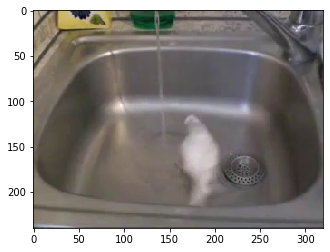

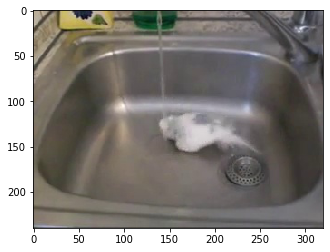

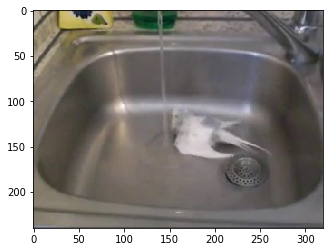

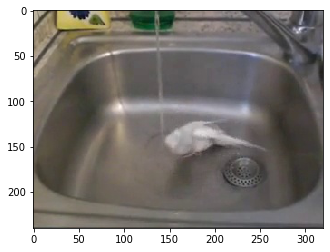

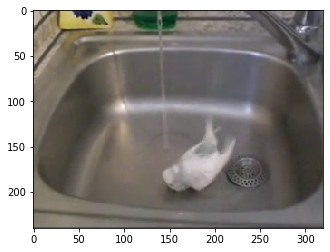

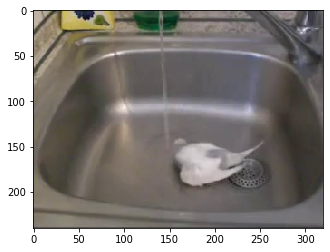

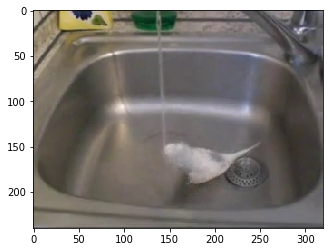

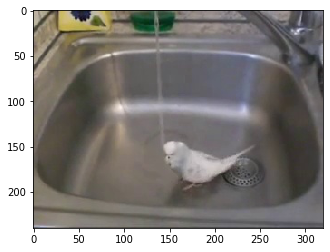

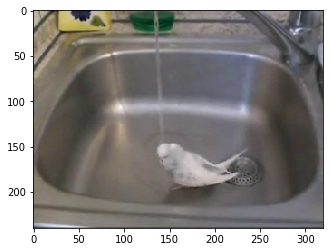

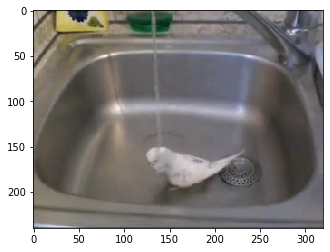

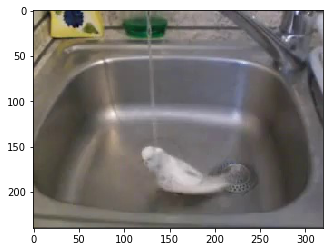

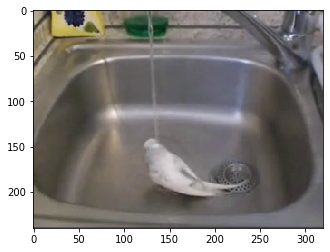

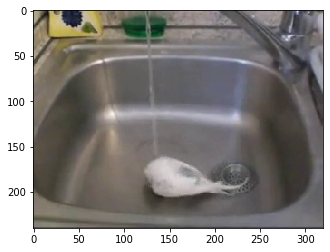

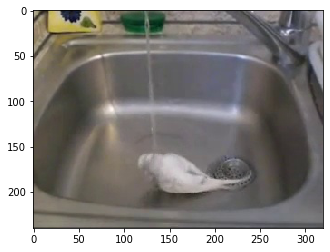

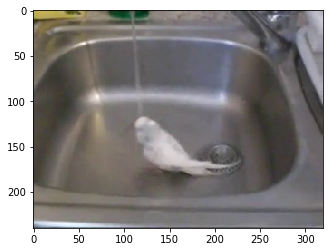

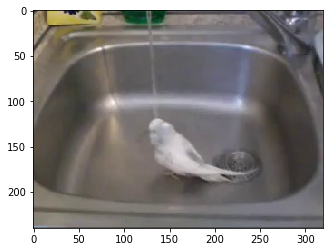

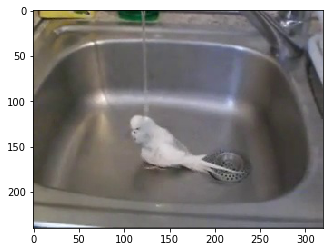

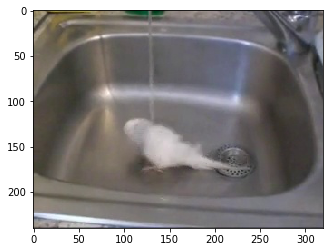

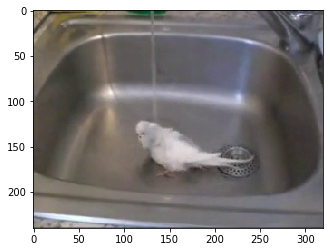

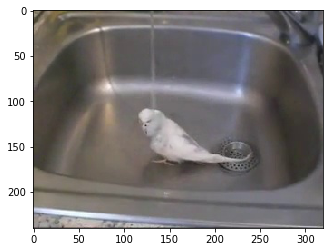

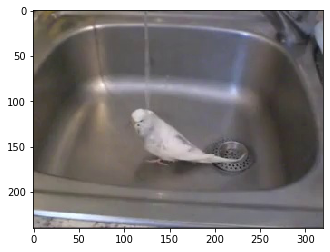

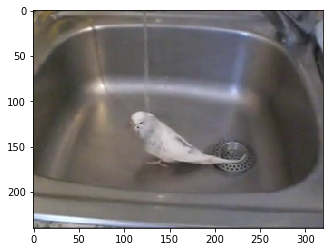

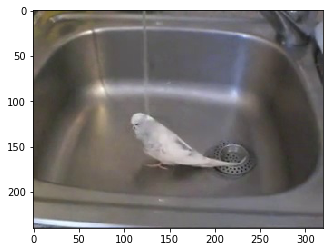

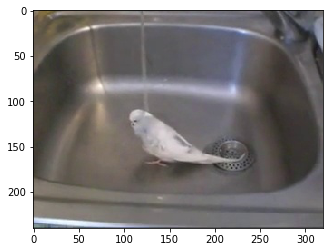

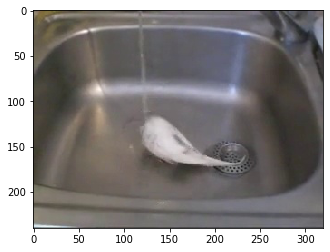

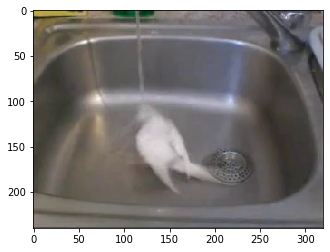

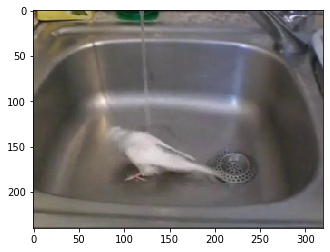

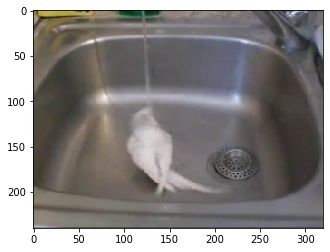

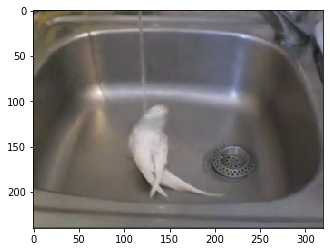

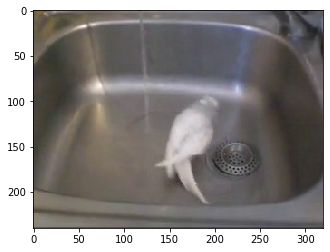

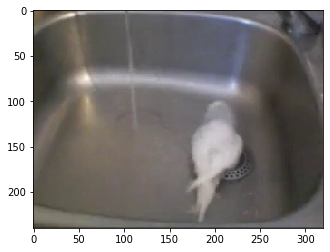

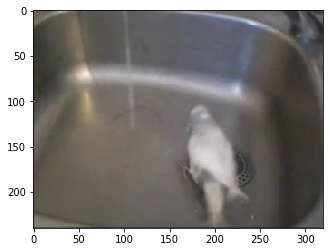

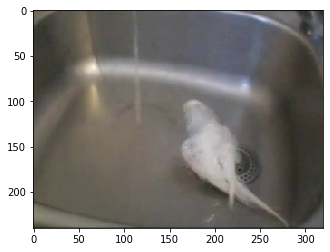

<Figure size 432x288 with 0 Axes>

In [17]:
view_frames('dataset/msvd_videos/frames/mv89psg6zh4_33_46')

In [18]:
#Let's use first 1200 videos for training.
train = data[:1200]
train.shape

(1200, 15, 4096)

In [19]:
#The data contains video extracted features.
#videos_selected contain video names & descriptions contains corresponding caption of those videos.

In [20]:
#Adding 'ssss' and 'eeee' to the descriptions.
for i in range(len(descriptions)):
    if descriptions[i][-1] == '.':
        descriptions[i] = 'ssss ' + descriptions[i][:-1] + ' eeee'
    else:
        descriptions[i] = 'ssss ' + descriptions[i] + ' eeee'

In [21]:
desc_len = [len(s.split(' ')) for s in descriptions]
max(desc_len) #Length of the largest caption. We will set max_length to this.

42

In [22]:
vocab_size = 2400
embedding_dim = 16
max_length = 20
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<oov>"

In [23]:
#Using Tokenizer to preprocess the descriptions.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(descriptions)

In [24]:
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(descriptions)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type, padding = padding_type)

In [25]:
#Let's look at padded sequences.
padded[:10]

array([[   3,    2,    6,    5,   16,   21,  353,  264,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,  105,    5,   16,  430,    4,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,   12,  538,   20,  158,   14,    2,   86,   35,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,    6,  431, 1021,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   20,   46,  688,   17,   89,  211,  173,  265,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,    6,    5,   47,  130,    2,  106,   10,   70,  107,
           5,   73,   25,  174,  107, 1022,  689,   49,   10],
       [   3,   68,   15,   94,    2,  692,    4,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,   12,  212,   25,    

In [27]:
##Updated##
"""
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# returns train, inference_encoder and inference_decoder models
def define_updated(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    embedding = Embedding(10000, 64)
    decoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True)
    
    temp = embedding(decoder_inputs)
    temp, _, _ = decoder_lstm1(temp, initial_state=encoder_states)
    decoder_outputs, _, _ = decoder_lstm2(temp, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    temp = embedding(decoder_inputs)
    temp, _, _ = decoder_lstm1(temp, initial_state=decoder_states_inputs)
    decoder_outputs, state_h, state_c = decoder_lstm2(temp, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    # return all models
    return model, encoder_model, decoder_model
"""

"\nfrom tensorflow.keras import Model\nfrom tensorflow.keras.layers import Input, LSTM, Dense, Embedding\n\n# returns train, inference_encoder and inference_decoder models\ndef define_updated(n_input, n_output, n_units):\n    # define training encoder\n    encoder_inputs = Input(shape=(None, n_input))\n    encoder = LSTM(n_units, return_state=True)\n    encoder_outputs, state_h, state_c = encoder(encoder_inputs)\n    encoder_states = [state_h, state_c]\n    \n    # define training decoder\n    decoder_inputs = Input(shape=(None, n_output))\n    embedding = Embedding(10000, 64)\n    decoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)\n    decoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True)\n    \n    temp = embedding(decoder_inputs)\n    temp, _, _ = decoder_lstm1(temp, initial_state=encoder_states)\n    decoder_outputs, _, _ = decoder_lstm2(temp, initial_state=encoder_states)\n    decoder_dense = Dense(n_output, activation='softmax')\n    \n    d

In [26]:
model, enc, dec = basic_enc_dec(4096, vocab_size, max_length)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4096)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 2400)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20), (None,  329360      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 20), ( 193680      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [30]:
x2 = np.hstack([np.zeros((1652, 1)), np.array(padded)])
x2 = x2[:, :-1]

In [31]:
#This is the output to be predicted.
padded[0]

array([   3,    2,   25,    5,  228,  538,  688,    9,  191,   17,   21,
        192, 1021,    4,    0,    0,    0,    0,    0,    0])

In [32]:
#This is the secondary input for decoder during training.
x2[0]

array([   0.,    3.,    2.,   25.,    5.,  228.,  538.,  688.,    9.,
        191.,   17.,   21.,  192., 1021.,    4.,    0.,    0.,    0.,
          0.,    0.])

In [33]:
x2.shape

(1652, 20)

In [34]:
#Convert to 1652x42x1
#x2 = x2.reshape(x2.shape + (1, ))
#out = padded.reshape(padded.shape + (1, ))

In [35]:
#Convert to 1652x42x1000
from keras.utils.np_utils import to_categorical   

x2_in = to_categorical(x2, num_classes = vocab_size)
outputs = to_categorical(padded, num_classes = vocab_size)
print(x2_in.shape, outputs.shape)

(1652, 20, 2400) (1652, 20, 2400)


Using TensorFlow backend.


In [36]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=7e-4), loss='categorical_crossentropy')
model.fit([train, x2_in[:1200]], outputs[:1200], epochs = 400)

Train on 1200 samples
Epoch 1/400
1200/1200 [==============================] - 9s 7ms/sample - loss: 7.4068
Epoch 2/400
1200/1200 [==============================] - 1s 970us/sample - loss: 6.6242
Epoch 3/400
1200/1200 [==============================] - 1s 996us/sample - loss: 5.8602
Epoch 4/400
1200/1200 [==============================] - 1s 918us/sample - loss: 5.1600s - loss: 5.165
Epoch 5/400
1200/1200 [==============================] - 1s 925us/sample - loss: 4.5800
Epoch 6/400
1200/1200 [==============================] - 2s 1ms/sample - loss: 4.1377
Epoch 7/400
1200/1200 [==============================] - 1s 928us/sample - loss: 3.8234
Epoch 8/400
1200/1200 [==============================] - 1s 1ms/sample - loss: 3.6225
Epoch 9/400
1200/1200 [==============================] - 1s 926us/sample - loss: 3.5266
Epoch 10/400
1200/1200 [==============================] - 1s 920us/sample - loss: 3.4974
Epoch 11/400
1200/1200 [==============================] - 1s 918us/sample - loss: 3.4870

Epoch 184/400
1200/1200 [==============================] - 1s 947us/sample - loss: 1.4465
Epoch 185/400
1200/1200 [==============================] - 1s 957us/sample - loss: 1.4412s 
Epoch 186/400
1200/1200 [==============================] - 2s 1ms/sample - loss: 1.4396
Epoch 187/400
1200/1200 [==============================] - 1s 928us/sample - loss: 1.4320
Epoch 188/400
1200/1200 [==============================] - 1s 1ms/sample - loss: 1.4309
Epoch 189/400
1200/1200 [==============================] - 1s 1ms/sample - loss: 1.4266
Epoch 190/400
1200/1200 [==============================] - 1s 913us/sample - loss: 1.4250
Epoch 191/400
1200/1200 [==============================] - 1s 946us/sample - loss: 1.4181
Epoch 192/400
1200/1200 [==============================] - 1s 1ms/sample - loss: 1.4147
Epoch 193/400
1200/1200 [==============================] - 1s 926us/sample - loss: 1.4095
Epoch 194/400
1200/1200 [==============================] - 1s 1ms/sample - loss: 1.4070
Epoch 195/400
1200

1200/1200 [==============================] - 1s 894us/sample - loss: 0.9119
Epoch 366/400
1200/1200 [==============================] - 1s 885us/sample - loss: 0.9106
Epoch 367/400
1200/1200 [==============================] - 1s 920us/sample - loss: 0.9073
Epoch 368/400
1200/1200 [==============================] - 1s 1ms/sample - loss: 0.9060
Epoch 369/400
1200/1200 [==============================] - 1s 892us/sample - loss: 0.9058s - loss: 0.906
Epoch 370/400
1200/1200 [==============================] - 1s 954us/sample - loss: 0.9030
Epoch 371/400
1200/1200 [==============================] - 1s 1ms/sample - loss: 0.8986
Epoch 372/400
1200/1200 [==============================] - 1s 947us/sample - loss: 0.8970
Epoch 373/400
1200/1200 [==============================] - 2s 1ms/sample - loss: 0.8974
Epoch 374/400
1200/1200 [==============================] - 1s 933us/sample - loss: 0.8931
Epoch 375/400
1200/1200 [==============================] - 2s 1ms/sample - loss: 0.8939
Epoch 376/400
120

In [37]:
# generate target given source sequence
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(word) for word in list_of_indices if word]
    return(words)
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0, 0, :])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    
    out = np.array(output).argmax(axis = 1)
    
    return ' '.join(sequence_to_text(out))

In [38]:
train[0:1].shape

(1, 15, 4096)

In [39]:
for i in range(20):
    print("Predicted:", predict_sequence(enc, dec, train[i:i+1], max_length, vocab_size))
    print("Actual:", descriptions[i])
    print()

Predicted: ssss someone woman is walking at an top in a dog in
Actual: ssss A person is adding cream, salt, and pepper to an egg mix eeee

Predicted: a woman pours to to to from a bowl of a pan eeee
Actual: ssss A woman adds noodles to a pan of boiling water and stirs with chopsticks eeee

Predicted: a man is shooting a banana eeee
Actual: ssss A man is shooting at a target eeee

Predicted: ssss someone in in in a a bowl eeee
Actual: ssss A person mixing ingredients in a mixing bowl eeee

Predicted: ssss a man is cutting a onion into a water eeee
Actual: ssss A man is finely chopping a green substance eeee

Predicted: ssss woman in a in a a car
Actual: ssss A dog biting on a can eeee

Predicted: ssss a person cutting up potatoes eeee
Actual: ssss a person cutting up potatoes eeee

Predicted: ssss someone is chopping on a piece off a knife with eeee
Actual: ssss A cat is watching something on a television or computer screen eeee

Predicted: a woman of his his a plastic is hands into a p

Predicted: ssss a man is riding a horse in with a large with eeee
Actual: ssss A woman is riding a horse in a pasture eeee



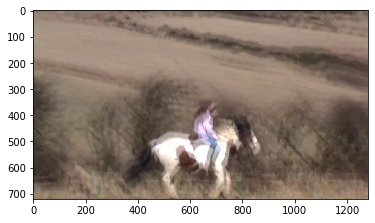

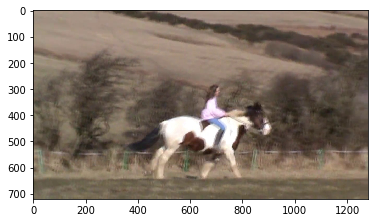

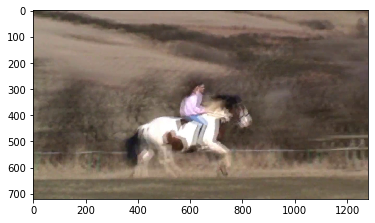

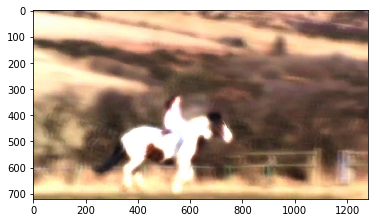

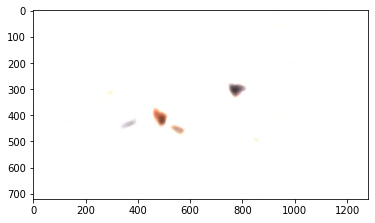

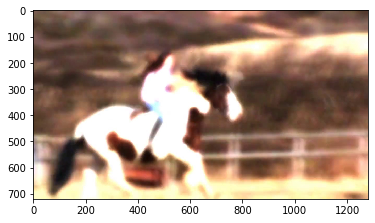

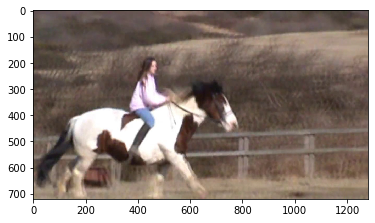

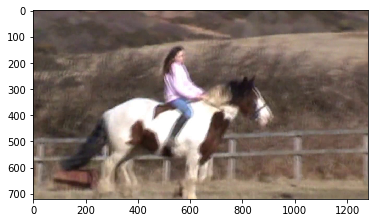

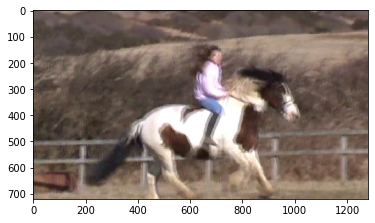

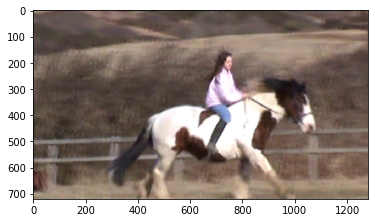

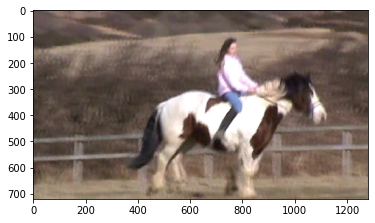

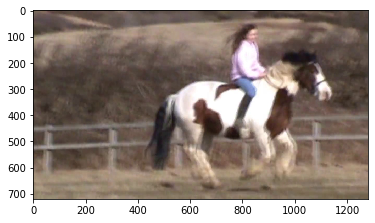

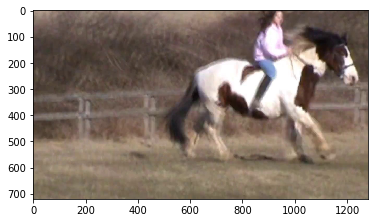

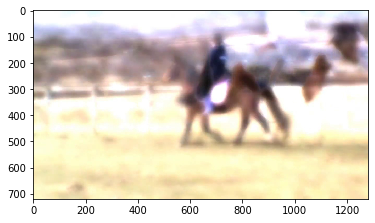

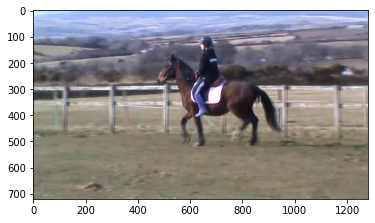

<Figure size 432x288 with 0 Axes>

In [44]:
idx = 100
view_frames('dataset/msvd_videos/frames/'+videos_selected[idx])
print("Predicted:", predict_sequence(enc, dec, train[idx:idx+1], max_length, vocab_size))
print("Actual:", descriptions[idx])
print()